<a href="https://colab.research.google.com/github/Nishorgo26/Project_2/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title ✅ Setup: GPU, deps, optional Drive
import sys, os, torch
print("Python:", sys.version)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Quiet installs
!pip -q install torchvision torchaudio scikit-learn matplotlib

# Optional: save to Drive
USE_DRIVE = False  #@param {type:"boolean"}
ARTIFACT_DIR = "/content/drive/MyDrive/vgg19_cifar10_prune_artifacts" if USE_DRIVE else "/content/artifacts"
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

os.makedirs(ARTIFACT_DIR, exist_ok=True)
print("Artifacts →", ARTIFACT_DIR)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
Artifacts → /content/artifacts


In [2]:
#@title 🔧 Imports, seeds, metrics, dataloaders, plotting (fixed)
import time, copy, random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)
from torch.nn.utils import prune

# Repro (keep cudnn fast)
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

CIFAR10_CLASSES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def build_dataloaders(data_root, batch_size, num_workers=2, val_ratio=0.1):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2470, 0.2435, 0.2616])
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        normalize
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), normalize])

    train_full = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tf)
    test_set   = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tf)

    n_val = int(len(train_full) * val_ratio)
    n_train = len(train_full) - n_val
    train_set, val_set = random_split(train_full, [n_train, n_val],
                                      generator=torch.Generator().manual_seed(123))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader

# === Plotting (matplotlib; no seaborn, no custom colors) ===
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

def plot_curves(history, outdir):
    # Loss
    plt.figure()
    plt.plot(history["epoch"], history["train_loss"], label="train_loss")
    plt.plot(history["epoch"], history["val_loss"],   label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True, linestyle=":")
    plt.title("Training vs Validation Loss")
    plt.tight_layout(); plt.savefig(Path(outdir)/"loss_curves.png"); plt.close()
    # Accuracy
    plt.figure()
    plt.plot(history["epoch"], history["train_acc"], label="train_acc")
    plt.plot(history["epoch"], history["val_acc"],   label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True, linestyle=":")
    plt.title("Training vs Validation Accuracy")
    plt.tight_layout(); plt.savefig(Path(outdir)/"acc_curves.png"); plt.close()

def plot_confusion(cm, classes, outpath, normalize=False, title="Confusion Matrix"):
    # FIX: dynamic formatting; ints for raw CM, .2f for normalized
    cm = np.array(cm)
    if normalize:
        cm = cm.astype(np.float64)
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)
        fmt = ".2f"
    else:
        if cm.dtype.kind == 'f':
            cm = np.rint(cm).astype(np.int64)
        fmt = "d"

    plt.figure(figsize=(6.5, 5.5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    Path(outpath).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(outpath); plt.close()

def plot_per_class_bars(report_dict, outstem):
    y_true, y_pred = report_dict.get("y_true"), report_dict.get("y_pred")
    if y_true is None or y_pred is None: return
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(range(10)), zero_division=0)
    x = np.arange(len(CIFAR10_CLASSES))
    # Precision
    plt.figure(); plt.bar(x, p); plt.xticks(x, CIFAR10_CLASSES, rotation=45, ha="right")
    plt.ylabel("Precision"); plt.title("Per-class Precision"); plt.tight_layout()
    plt.savefig(f"{outstem}_precision.png"); plt.close()
    # Recall
    plt.figure(); plt.bar(x, r); plt.xticks(x, CIFAR10_CLASSES, rotation=45, ha="right")
    plt.ylabel("Recall"); plt.title("Per-class Recall"); plt.tight_layout()
    plt.savefig(f"{outstem}_recall.png"); plt.close()
    # F1
    plt.figure(); plt.bar(x, f1); plt.xticks(x, CIFAR10_CLASSES, rotation=45, ha="right")
    plt.ylabel("F1-score"); plt.title("Per-class F1-score"); plt.tight_layout()
    plt.savefig(f"{outstem}_f1.png"); plt.close()


In [3]:
#@title 🧠 Model (VGG19), train/eval, structured pruning, sparsity
def build_vgg19(num_classes=10, pretrained=False):
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT if pretrained else None)
    in_features = model.classifier[-1].in_features
    head = list(model.classifier.children())
    head[-1] = nn.Linear(in_features, num_classes)
    model.classifier = nn.Sequential(*head)
    return model

def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if scaler:
            with torch.autocast(device_type=device.type, dtype=torch.float16):
                logits = model(x); loss = criterion(logits, y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            logits = model(x); loss = criterion(logits, y)
            loss.backward(); optimizer.step()
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, device, return_preds=False):
    model.eval()
    y_true, y_pred = [], []
    total, running_loss = 0, 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x); loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        y_true.append(y.cpu().numpy()); y_pred.append(pred.cpu().numpy())
        total += y.size(0)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    p_mac, r_mac, f1_mac, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    p_mic, r_mic, f1_mic, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    return {
        "loss": running_loss / total,
        "accuracy": acc,
        "precision_macro": p_mac, "recall_macro": r_mac, "f1_macro": f1_mac,
        "precision_micro": p_mic, "recall_micro": r_mic, "f1_micro": f1_mic,
        "confusion_matrix": cm,
        "y_true": y_true if return_preds else None,
        "y_pred": y_pred if return_preds else None,
        "class_report": classification_report(y_true, y_pred, target_names=CIFAR10_CLASSES, zero_division=0)
    }

def prune_for_inference(model, amount=0.3, structured=True, progressive=True):
    """
    Structured pruning by default.
      - Conv2d: prune output channels (dim=0) by L2 norm
      - Linear: prune output units (dim=0)
    progressive=True → slightly more pruning in deeper layers.
    Note: shapes are not physically shrunk; channels are zeroed (structured sparsity).
    """
    m = copy.deepcopy(model)
    # collect target layers
    targets = [mod for mod in m.modules() if isinstance(mod, (nn.Conv2d, nn.Linear))]
    if not targets:
        return m

    if structured:
        if progressive and len(targets) > 1:
            import torch as _torch
            scales = _torch.linspace(0.8, 1.2, steps=len(targets)).tolist()
            per_layer = [max(0.0, min(0.95, s * amount)) for s in scales]
        else:
            per_layer = [max(0.0, min(0.95, amount))] * len(targets)

        for mod, amt in zip(targets, per_layer):
            if isinstance(mod, nn.Conv2d):
                prune.ln_structured(mod, name="weight", amount=amt, n=2, dim=0)  # drop output channels
                prune.remove(mod, "weight")
            elif isinstance(mod, nn.Linear):
                prune.ln_structured(mod, name="weight", amount=amt, n=2, dim=0)  # drop output units
                prune.remove(mod, "weight")
    else:
        for mod in targets:
            prune.l1_unstructured(mod, name="weight", amount=amount)
            prune.remove(mod, "weight")
    return m

@torch.no_grad()
def report_sparsity(model):
    zeros_total, params_total = 0, 0
    details = []
    for name, p in model.named_parameters():
        if p is None or p.numel() == 0:
            continue
        num = p.numel()
        z = (p == 0).sum().item()
        frac = z / num
        zeros_total += z; params_total += num
        details.append((name, z, num, frac))
    global_frac = zeros_total / params_total if params_total > 0 else 0.0
    return global_frac, details


Device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


VGG19 params: total=139.61M, trainable=139.61M

=== TRAINING ===


/tmp/ipython-input-2050508498.py:324: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Epoch 01/40 | tr_loss 2.2787 tr_acc 0.1214 | val_loss 2.1995 val_acc 0.1596 | val_f1(macro) 0.1010 | 51.6s
Epoch 02/40 | tr_loss 2.1279 tr_acc 0.1888 | val_loss 2.0539 val_acc 0.2172 | val_f1(macro) 0.1509 | 19.9s
Epoch 03/40 | tr_loss 1.9572 tr_acc 0.2472 | val_loss 1.8699 val_acc 0.2866 | val_f1(macro) 0.2403 | 19.9s
Epoch 04/40 | tr_loss 1.8236 tr_acc 0.3074 | val_loss 1.7477 val_acc 0.3522 | val_f1(macro) 0.3223 | 19.8s
Epoch 05/40 | tr_loss 1.7008 tr_acc 0.3634 | val_loss 1.5831 val_acc 0.4172 | val_f1(macro) 0.3974 | 19.9s
Epoch 06/40 | tr_loss 1.5377 tr_acc 0.4366 | val_loss 1.4382 val_acc 0.4782 | val_f1(macro) 0.4596 | 20.0s
Epoch 07/40 | tr_loss 1.4053 tr_acc 0.4914 | val_loss 1.3486 val_acc 0.5112 | val_f1(macro) 0.4976 | 19.8s
Epoch 08/40 | tr_loss 1.2834 tr_acc 0.5359 | val_loss 1.2878 val_acc 0.5428 | val_f1(macro) 0.5354 | 19.8s
Epoch 09/40 | tr_loss 1.2150 tr_acc 0.5638 | val_loss 1.1380 val_acc 0.5902 | val_f1(macro) 0.5897 | 19.8s
Epoch 10/40 | tr_loss 1.1420 tr_acc 0

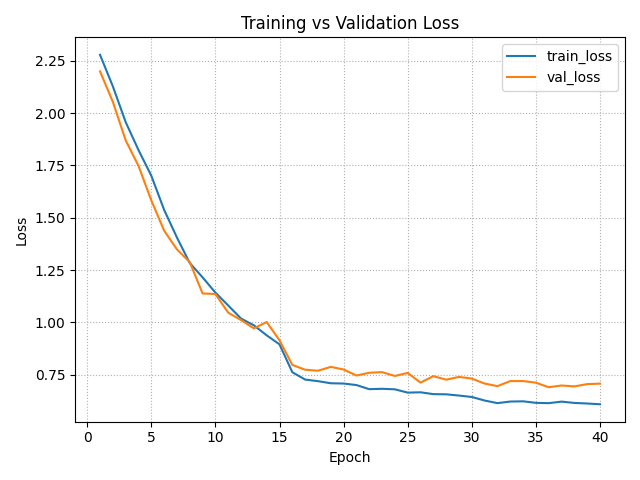

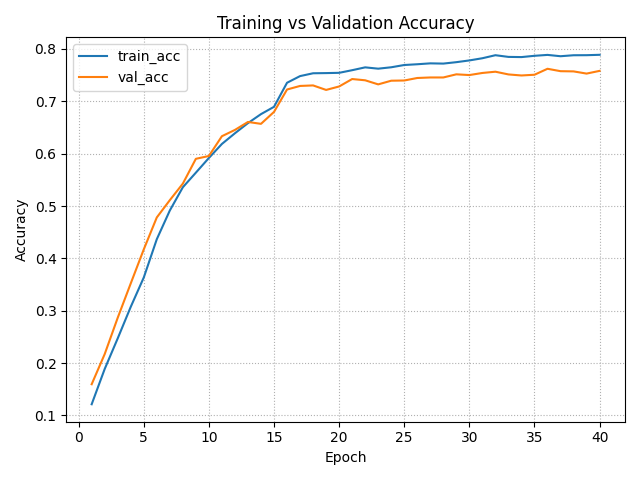

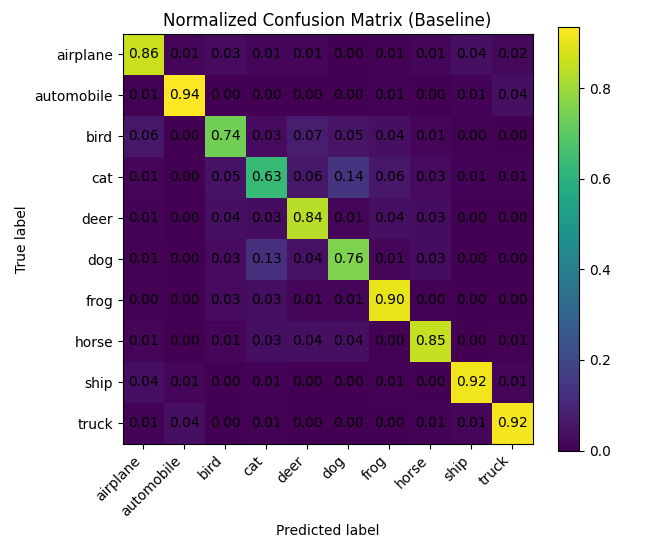


=== APPLY PRUNING (inference) | structured=True, amount=0.3 ===
Global weight sparsity after pruning: 30.01%

=== TEST: Pruned ===
              precision    recall  f1-score   support

    airplane       1.00      0.01      0.01      1000
  automobile       1.00      0.05      0.09      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.14      0.99      0.25      1000
         dog       0.00      0.00      0.00      1000
        frog       0.21      0.57      0.30      1000
       horse       0.00      0.00      0.00      1000
        ship       1.00      0.04      0.08      1000
       truck       0.97      0.22      0.36      1000

    accuracy                           0.19     10000
   macro avg       0.43      0.19      0.11     10000
weighted avg       0.43      0.19      0.11     10000

Pruned  Acc: 0.1881 | F1(macro): 0.1098


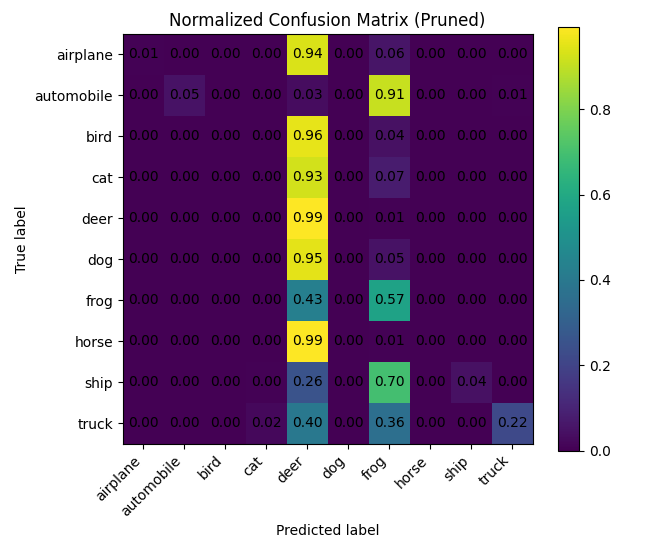


=== FINE-TUNE (pruned model) ===
FT 01/5 | tr_loss 1.3659 tr_acc 0.5497 | val_loss 1.0109 val_acc 0.6480 | val_f1(macro) 0.6229
FT 02/5 | tr_loss 0.9139 tr_acc 0.6810 | val_loss 0.8735 val_acc 0.6912 | val_f1(macro) 0.6816
FT 03/5 | tr_loss 0.8335 tr_acc 0.7148 | val_loss 0.8525 val_acc 0.7040 | val_f1(macro) 0.6988
FT 04/5 | tr_loss 0.8048 tr_acc 0.7239 | val_loss 0.8422 val_acc 0.7178 | val_f1(macro) 0.7166
FT 05/5 | tr_loss 0.7798 tr_acc 0.7336 | val_loss 0.8283 val_acc 0.7188 | val_f1(macro) 0.7176

=== TEST: Pruned + Fine-Tuned ===
              precision    recall  f1-score   support

    airplane       0.82      0.83      0.82      1000
  automobile       0.90      0.93      0.92      1000
        bird       0.71      0.67      0.69      1000
         cat       0.70      0.46      0.56      1000
        deer       0.78      0.79      0.78      1000
         dog       0.63      0.77      0.69      1000
        frog       0.75      0.90      0.82      1000
       horse       0.84

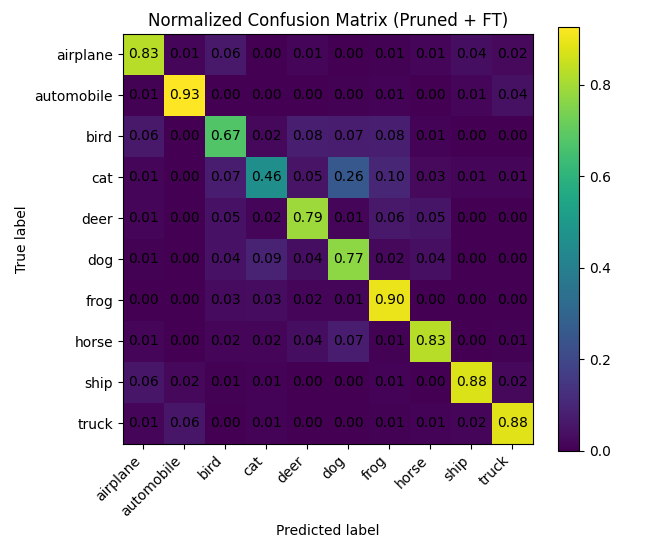


=== COMPARISON (test) ===
Model     | Acc    | Prec(mac) | Rec(mac) | F1(mac)
----------+--------+-----------+----------+--------
Baseline  | 0.8337 | 0.8328    | 0.8337   | 0.8327 
Pruned    | 0.1881 | 0.4324    | 0.1881   | 0.1098 
Pruned+FT | 0.7931 | 0.7941    | 0.7931   | 0.7897 

=== HARDWARE METRICS ===
Hardware: {'python': '3.12.11', 'pytorch': '2.8.0+cu126', 'cuda_available': True, 'device': 'cuda', 'gpu_name': 'NVIDIA A100-SXM4-80GB', 'capability': (8, 0), 'cuda_version': '12.6'}
Baseline   | bs=  1 |    2.66 ms |    375.5 img/s
Baseline   | bs= 16 |    2.67 ms |   6001.0 img/s
Baseline   | bs= 64 |    2.77 ms |  23074.7 img/s
Baseline   | bs=128 |    2.93 ms |  43664.8 img/s
Pruned     | bs=  1 |    2.66 ms |    376.0 img/s
Pruned     | bs= 16 |    2.65 ms |   6033.8 img/s
Pruned     | bs= 64 |    2.74 ms |  23359.1 img/s
Pruned     | bs=128 |    2.91 ms |  44007.8 img/s
Pruned+FT  | bs=  1 |    2.66 ms |    376.2 img/s
Pruned+FT  | bs= 16 |    2.64 ms |   6071.7 img/s
Prun

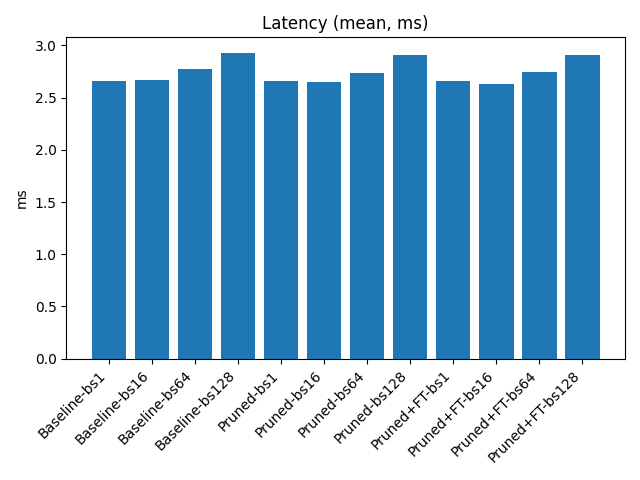

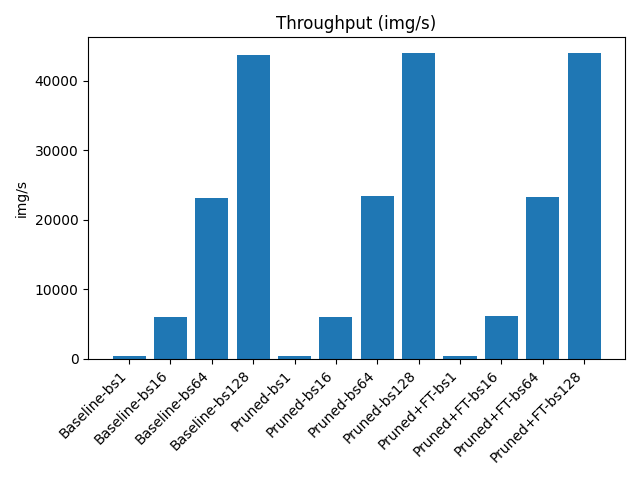

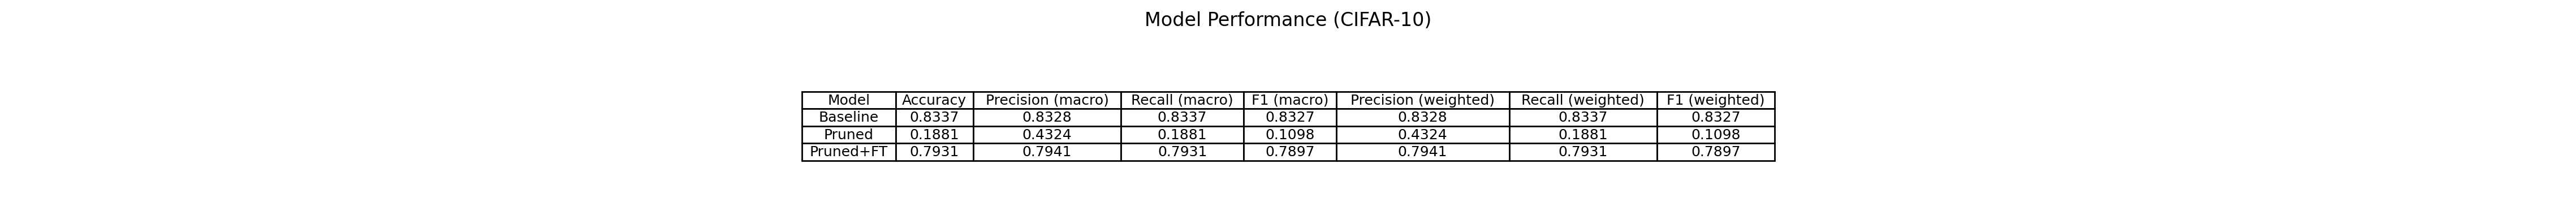

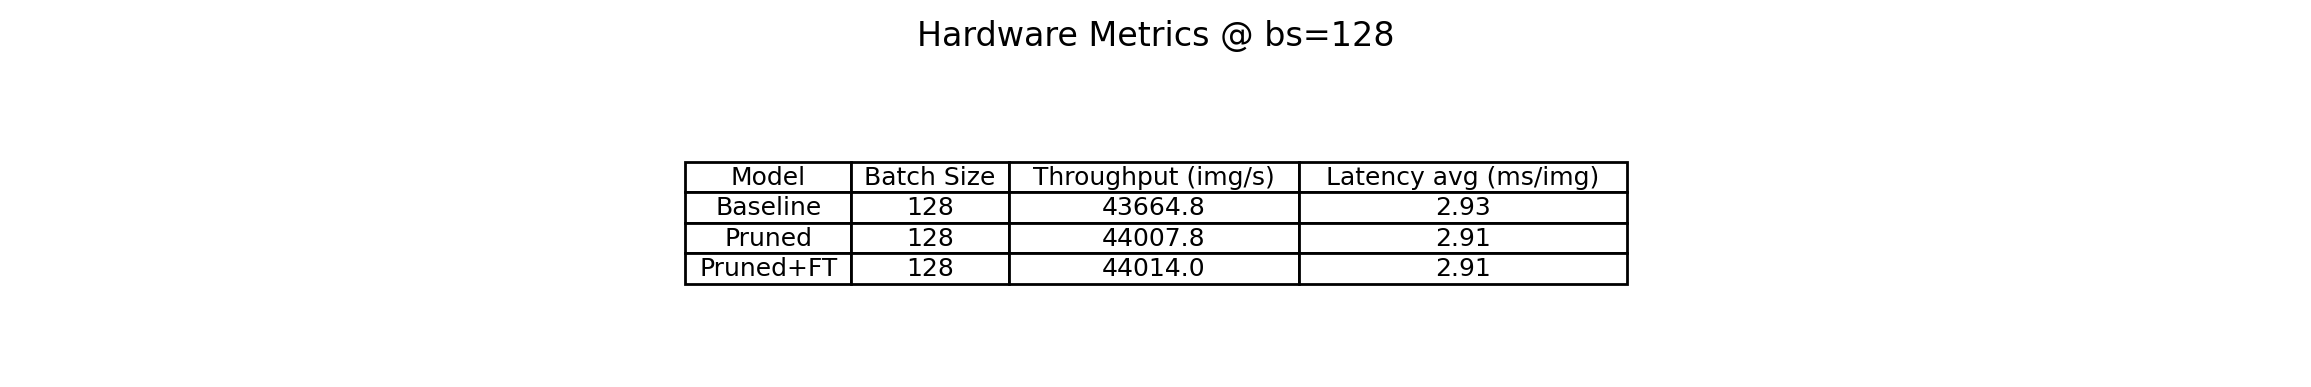


=== VERDICT ===
- Accuracy/F1 Δ (Pruned vs Base): ΔAcc -0.6456, ΔF1 -0.7230
- Accuracy/F1 Δ (Pruned+FT vs Base): ΔAcc -0.0406, ΔF1 -0.0431
- Latency/Throughput @ bs=128: Pruned 2.91 ms / 44007.8 img/s vs Base 2.93 ms / 43664.8 img/s
  Pruned+FT 2.91 ms / 44014.0 img/s vs Base
- Structured pruning zeros whole channels/units. For larger speedups, add channel packing or export to an engine that eliminates dead channels.


In [4]:
#@title 🚀 VGG19 on CIFAR-10: Train → Prune → Evaluate → Hardware Metrics (Latency/Throughput) + Plots + Verdict

# ===========================
# Knobs
# ===========================
SEED = 42                 #@param {type:"integer"}
EPOCHS = 40               #@param {type:"integer"}
BATCH  = 256              #@param {type:"integer"}
LR     = 0.01             #@param {type:"number"}
MOMENTUM = 0.9            #@param {type:"number"}
WEIGHT_DECAY = 5e-4       #@param {type:"number"}
STEP_SIZE = 15            #@param {type:"integer"}
GAMMA     = 0.1           #@param {type:"number"}

# Pruning behavior
STRUCTURED   = True       # True = channel/unit pruning (L2, dim=0); False = unstructured L1
PRUNE_AMOUNT = 0.30       # 0.2–0.5 typical; >0.3 usually needs FT

# Plotting & Fine-tuning
PLOT = True               # save & show plots
DO_FT = True              # fine-tune pruned model to recover accuracy
FINE_TUNE_EPOCHS = 5
FINE_TUNE_LR     = 5e-4

# Hardware benchmarking
BENCH_BATCH_SIZES = [1, 16, 64, 128]   # adjust for VRAM
BENCH_ITERS       = 120
BENCH_WARMUP      = 20

ARTIFACT_DIR = "/content/artifacts"

# ===========================
# Imports & Setup
# ===========================
import sys, os, time, copy, random, platform, json
import numpy as np
from pathlib import Path
from statistics import mean, median

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)
from torch.nn.utils import prune

# quiet install for thop (FLOPs/MACs)
!pip -q install thop
from thop import profile

# plotting
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from IPython.display import Image, display

# ensure artifacts dir
outdir = Path(ARTIFACT_DIR); outdir.mkdir(parents=True, exist_ok=True)

# ===========================
# Utils: seeds, data, model
# ===========================
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

CIFAR10_CLASSES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def build_dataloaders(data_root, batch_size, num_workers=2, val_ratio=0.1):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2470, 0.2435, 0.2616])
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        normalize
    ])
    test_tf = transforms.Compose([transforms.ToTensor(), normalize])

    train_full = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tf)
    test_set   = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tf)

    n_val = int(len(train_full) * val_ratio)
    n_train = len(train_full) - n_val
    train_set, val_set = random_split(train_full, [n_train, n_val],
                                      generator=torch.Generator().manual_seed(123))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader

def build_vgg19(num_classes=10, pretrained=False):
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT if pretrained else None)
    in_features = model.classifier[-1].in_features
    head = list(model.classifier.children())
    head[-1] = nn.Linear(in_features, num_classes)
    model.classifier = nn.Sequential(*head)
    return model

# ===========================
# Train / Eval
# ===========================
def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if scaler:
            with torch.autocast(device_type=device.type, dtype=torch.float16):
                logits = model(x); loss = criterion(logits, y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            logits = model(x); loss = criterion(logits, y)
            loss.backward(); optimizer.step()
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, device, return_preds=False):
    model.eval()
    y_true, y_pred = [], []
    total, running_loss = 0, 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        y_true.append(y.cpu().numpy()); y_pred.append(pred.cpu().numpy())
        total += y.size(0)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    p_mac, r_mac, f1_mac, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    p_mic, r_mic, f1_mic, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    return {
        "loss": running_loss / total,
        "accuracy": acc,
        "precision_macro": p_mac, "recall_macro": r_mac, "f1_macro": f1_mac,
        "precision_micro": p_mic, "recall_micro": r_mic, "f1_micro": f1_mic,
        "confusion_matrix": cm,
        "y_true": y_true if return_preds else None,
        "y_pred": y_pred if return_preds else None,
        "class_report": classification_report(y_true, y_pred, target_names=CIFAR10_CLASSES, zero_division=0)
    }

# ===========================
# Pruning (per your spec)
# ===========================
def prune_for_inference(model, amount=0.3, structured=True):
    """
    structured=True  → drop entire output channels/units (L2, dim=0) via ln_structured
    structured=False → zero individual weights (L1) via l1_unstructured
    In both modes, prune.remove(...) makes sparsity permanent (removes reparam hooks).
    """
    m = copy.deepcopy(model)
    for mod in m.modules():
        if isinstance(mod, (nn.Conv2d, nn.Linear)):
            if structured:
                prune.ln_structured(mod, name="weight", amount=amount, n=2, dim=0)
                prune.remove(mod, "weight")
            else:
                prune.l1_unstructured(mod, name="weight", amount=amount)
                prune.remove(mod, "weight")
    return m

@torch.no_grad()
def report_sparsity(model):
    zeros_total, params_total = 0, 0
    for _, p in model.named_parameters():
        if p is None or p.numel() == 0:
            continue
        params_total += p.numel()
        zeros_total  += (p == 0).sum().item()
    return zeros_total / params_total if params_total > 0 else 0.0

# ===========================
# Plots (confusion fix included)
# ===========================
def plot_curves(history, outdir):
    # Loss
    plt.figure()
    plt.plot(history["epoch"], history["train_loss"], label="train_loss")
    plt.plot(history["epoch"], history["val_loss"],   label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True, linestyle=":")
    plt.title("Training vs Validation Loss")
    plt.tight_layout(); plt.savefig(Path(outdir)/"loss_curves.png"); plt.close()
    # Accuracy
    plt.figure()
    plt.plot(history["epoch"], history["train_acc"], label="train_acc")
    plt.plot(history["epoch"], history["val_acc"],   label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True, linestyle=":")
    plt.title("Training vs Validation Accuracy")
    plt.tight_layout(); plt.savefig(Path(outdir)/"acc_curves.png"); plt.close()

def plot_confusion(cm, classes, outpath, normalize=False, title="Confusion Matrix"):
    cm = np.array(cm)
    if normalize:
        cm = cm.astype(np.float64)
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)
        fmt = ".2f"
    else:
        if cm.dtype.kind == 'f':
            cm = np.rint(cm).astype(np.int64)
        fmt = "d"
    plt.figure(figsize=(6.5, 5.5)); plt.imshow(cm, interpolation='nearest'); plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes)); plt.xticks(ticks, classes, rotation=45, ha="right"); plt.yticks(ticks, classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    Path(outpath).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(outpath); plt.close()

def plot_per_class_bars(report_dict, outstem):
    y_true, y_pred = report_dict.get("y_true"), report_dict.get("y_pred")
    if y_true is None or y_pred is None: return
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(range(10)), zero_division=0)
    x = np.arange(len(CIFAR10_CLASSES))
    for name, vals in [("precision", p), ("recall", r), ("f1", f1)]:
        plt.figure(); plt.bar(x, vals); plt.xticks(x, CIFAR10_CLASSES, rotation=45, ha="right")
        plt.ylabel(name.capitalize()); plt.title(f"Per-class {name.capitalize()}"); plt.tight_layout()
        plt.savefig(f"{outstem}_{name}.png"); plt.close()

def plot_bar(x, y, title, ylabel, outpath):
    plt.figure(); plt.bar(x, y); plt.xticks(rotation=45, ha="right")
    plt.title(title); plt.ylabel(ylabel); plt.tight_layout(); plt.savefig(outpath); plt.close()

# ===========================
# Hardware metrics helpers
# ===========================
def hardware_info(outdir):
    info = {
        "python": platform.python_version(),
        "pytorch": torch.__version__,
        "cuda_available": torch.cuda.is_available(),
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "gpu_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
        "capability": torch.cuda.get_device_capability(0) if torch.cuda.is_available() else None,
        "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
    }
    with open(Path(outdir)/"hardware_info.json", "w") as f:
        json.dump(info, f, indent=2)
    print("Hardware:", info)
    return info

@torch.no_grad()
def flops_and_params(model, input_shape=(1,3,32,32), device="cuda"):
    model = model.to(device).eval()
    dummy = torch.randn(*input_shape, device=device)
    macs, params = profile(model, inputs=(dummy,), verbose=False)
    gmacs = macs / 1e9
    mparams = params / 1e6
    return gmacs, mparams

@torch.no_grad()
def benchmark_latency(model, batch_size=128, iters=120, warmup=20, use_amp=True, device="cuda"):
    model = model.to(device).eval()
    x = torch.randn(batch_size, 3, 32, 32, device=device)
    timings = []
    if device == "cuda":
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        # warmup
        for _ in range(warmup):
            with torch.autocast(device_type="cuda", dtype=torch.float16) if use_amp else torch.cuda.amp.autocast(enabled=False):
                _ = model(x)
        torch.cuda.synchronize()
        # timed runs
        for _ in range(iters):
            starter.record()
            with torch.autocast(device_type="cuda", dtype=torch.float16) if use_amp else torch.cuda.amp.autocast(enabled=False):
                _ = model(x)
            ender.record(); torch.cuda.synchronize()
            timings.append(starter.elapsed_time(ender))  # ms
    else:
        # CPU timing
        for _ in range(warmup):
            _ = model(x)
        for _ in range(iters):
            t0 = time.perf_counter(); _ = model(x); t1 = time.perf_counter()
            timings.append((t1 - t0) * 1000.0)  # ms

    timings = np.array(timings, dtype=np.float64)
    lat_mean = timings.mean()
    thr = (batch_size / (lat_mean / 1000.0))
    return float(lat_mean), float(thr)

# ===========================
# Run: Train → Eval → Prune → Eval → (FT) → Hardware
# ===========================
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_loader, val_loader, test_loader = build_dataloaders("/content/data", BATCH)

model = build_vgg19(num_classes=10, pretrained=False).to(device)
tot, trn = count_params(model)
print(f"VGG19 params: total={tot/1e6:.2f}M, trainable={trn/1e6:.2f}M")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}
best_val_f1, best_state = -1.0, copy.deepcopy(model.state_dict())

print("\n=== TRAINING ===")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_rep = evaluate(model, val_loader, device)
    scheduler.step()

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_rep["loss"])
    history["val_acc"].append(val_rep["accuracy"])
    history["lr"].append(optimizer.param_groups[0]["lr"])

    if val_rep["f1_macro"] > best_val_f1:
        best_val_f1 = val_rep["f1_macro"]; best_state = copy.deepcopy(model.state_dict())

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | tr_loss {tr_loss:.4f} tr_acc {tr_acc:.4f} "
          f"| val_loss {val_rep['loss']:.4f} val_acc {val_rep['accuracy']:.4f} "
          f"| val_f1(macro) {val_rep['f1_macro']:.4f} | {dt:.1f}s")

# load best
model.load_state_dict(best_state)

# Baseline test
print("\n=== TEST: Baseline (no pruning) ===")
base_rep = evaluate(model, test_loader, device, return_preds=True)
print(base_rep["class_report"])
print(f"Baseline Acc: {base_rep['accuracy']:.4f} | F1(macro): {base_rep['f1_macro']:.4f}")

# Save & plots
torch.save(model.state_dict(), outdir/"vgg19_cifar10_baseline.pt")
np.save(outdir/"history.npy", history, allow_pickle=True)
if PLOT:
    plot_curves(history, outdir)
    plot_confusion(base_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_baseline_raw.png",
                   normalize=False, title="Confusion Matrix (Baseline)")
    plot_confusion(base_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_baseline_norm.png",
                   normalize=True,  title="Normalized Confusion Matrix (Baseline)")
    plot_per_class_bars(base_rep, str(outdir/"baseline_perclass"))
    display(Image(filename=outdir/"loss_curves.png"))
    display(Image(filename=outdir/"acc_curves.png"))
    display(Image(filename=outdir/"cm_baseline_norm.png"))

# Prune
print(f"\n=== APPLY PRUNING (inference) | structured={STRUCTURED}, amount={PRUNE_AMOUNT} ===")
pruned_model = prune_for_inference(model, amount=PRUNE_AMOUNT, structured=STRUCTURED).to(device)
torch.save(pruned_model.state_dict(), outdir/"vgg19_cifar10_pruned.pt")
sparsity = report_sparsity(pruned_model)
print(f"Global weight sparsity after pruning: {100*sparsity:.2f}%")

print("\n=== TEST: Pruned ===")
pruned_rep = evaluate(pruned_model, test_loader, device, return_preds=True)
print(pruned_rep["class_report"])
print(f"Pruned  Acc: {pruned_rep['accuracy']:.4f} | F1(macro): {pruned_rep['f1_macro']:.4f}")
if PLOT:
    plot_confusion(pruned_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_pruned_raw.png",
                   normalize=False, title="Confusion Matrix (Pruned)")
    plot_confusion(pruned_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_pruned_norm.png",
                   normalize=True,  title="Normalized Confusion Matrix (Pruned)")
    plot_per_class_bars(pruned_rep, str(outdir/"pruned_perclass"))
    display(Image(filename=outdir/"cm_pruned_norm.png"))

# Optional fine-tune
ft_model, ft_rep = None, None
if DO_FT:
    print("\n=== FINE-TUNE (pruned model) ===")
    ft_model = copy.deepcopy(pruned_model).to(device)
    optimizer_ft = optim.SGD(ft_model.parameters(), lr=FINE_TUNE_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler_ft = StepLR(optimizer_ft, step_size=max(1, FINE_TUNE_EPOCHS//2), gamma=0.5)
    for e in range(1, FINE_TUNE_EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(ft_model, train_loader, criterion, optimizer_ft, device)
        val_rep = evaluate(ft_model, val_loader, device)
        scheduler_ft.step()
        print(f"FT {e:02d}/{FINE_TUNE_EPOCHS} | tr_loss {tr_loss:.4f} tr_acc {tr_acc:.4f} "
              f"| val_loss {val_rep['loss']:.4f} val_acc {val_rep['accuracy']:.4f} "
              f"| val_f1(macro) {val_rep['f1_macro']:.4f}")
    ft_rep = evaluate(ft_model, test_loader, device, return_preds=True)
    print("\n=== TEST: Pruned + Fine-Tuned ===")
    print(ft_rep["class_report"])
    print(f"Pruned+FT Acc: {ft_rep['accuracy']:.4f} | F1(macro): {ft_rep['f1_macro']:.4f}")
    torch.save(ft_model.state_dict(), outdir/"vgg19_cifar10_pruned_finetuned.pt")
    if PLOT:
        plot_confusion(ft_rep["confusion_matrix"], CIFAR10_CLASSES, outdir/"cm_pruned_ft_norm.png",
                       normalize=True, title="Normalized Confusion Matrix (Pruned + FT)")
        plot_per_class_bars(ft_rep, str(outdir/"pruned_ft_perclass"))
        display(Image(filename=outdir/"cm_pruned_ft_norm.png"))

# Comparison table
def row(name, rep):
    return [name, f"{rep['accuracy']:.4f}", f"{rep['precision_macro']:.4f}", f"{rep['recall_macro']:.4f}", f"{rep['f1_macro']:.4f}"]
header = ["Model", "Acc", "Prec(mac)", "Rec(mac)", "F1(mac)"]
rows = [header, row("Baseline", base_rep), row("Pruned", pruned_rep)]
if ft_rep is not None: rows.append(row("Pruned+FT", ft_rep))
colw = [max(len(r[i]) for r in rows) for i in range(len(header))]
print("\n=== COMPARISON (test) ===")
print(" | ".join(h.ljust(colw[i]) for i, h in enumerate(header)))
print("-+-".join("-"*colw[i] for i in range(len(header))))
for r in rows[1:]:
    print(" | ".join(r[i].ljust(colw[i]) for i in range(len(header))))

# ===========================
# ⚙️ Hardware metrics & plots (+ verdict tables)
# ===========================
# ---- knobs for benchmarking ----
BENCH_BATCH_SIZES = [1, 16, 64, 128]   # adjust if VRAM is tight
BENCH_ITERS       = 120
BENCH_WARMUP      = 20

# ---- deps / imports (safe to re-import) ----
import platform, json, pandas as pd
from IPython.display import Image, display

# THOP for MACs/params
try:
    from thop import profile
except Exception:
    !pip -q install thop
    from thop import profile

# ---- helper defs (only define if missing) ----
def _ensure_path(p): Path(p).parent.mkdir(parents=True, exist_ok=True)

if 'hardware_info' not in globals():
    def hardware_info(outdir):
        info = {
            "python": platform.python_version(),
            "pytorch": torch.__version__,
            "cuda_available": torch.cuda.is_available(),
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            "gpu_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
            "capability": torch.cuda.get_device_capability(0) if torch.cuda.is_available() else None,
            "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
        }
        with open(Path(outdir)/"hardware_info.json", "w") as f:
            json.dump(info, f, indent=2)
        return info

if 'flops_and_params' not in globals():
    @torch.no_grad()
    def flops_and_params(model, input_shape=(1,3,32,32), device="cuda"):
        model = model.to(device).eval()
        dummy = torch.randn(*input_shape, device=device)
        macs, params = profile(model, inputs=(dummy,), verbose=False)
        return macs/1e9, params/1e6  # GMACs, MParams

if 'benchmark_latency' not in globals():
    @torch.no_grad()
    def benchmark_latency(model, batch_size=128, iters=120, warmup=20, use_amp=True, device="cuda"):
        model = model.to(device).eval()
        x = torch.randn(batch_size, 3, 32, 32, device=device)
        times = []
        if device == "cuda":
            starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
            # warmup
            for _ in range(warmup):
                with torch.autocast(device_type="cuda", dtype=torch.float16) if use_amp else torch.cuda.amp.autocast(enabled=False):
                    _ = model(x)
            torch.cuda.synchronize()
            # timed
            for _ in range(iters):
                starter.record()
                with torch.autocast(device_type="cuda", dtype=torch.float16) if use_amp else torch.cuda.amp.autocast(enabled=False):
                    _ = model(x)
                ender.record(); torch.cuda.synchronize()
                times.append(starter.elapsed_time(ender))  # ms
        else:
            # CPU timing
            for _ in range(warmup):
                _ = model(x)
            for _ in range(iters):
                t0 = time.perf_counter(); _ = model(x); t1 = time.perf_counter()
                times.append((t1 - t0) * 1000.0)  # ms
        lat_ms = float(np.mean(times))
        thr = float(batch_size / (lat_ms/1000.0))
        return lat_ms, thr

if 'plot_bar' not in globals():
    def plot_bar(x, y, title, ylabel, outpath):
        plt.figure(); plt.bar(x, y)  # no custom colors/styles
        plt.xticks(rotation=45, ha="right")
        plt.title(title); plt.ylabel(ylabel)
        plt.tight_layout(); _ensure_path(outpath); plt.savefig(outpath); plt.close()

print("\n=== HARDWARE METRICS ===")
hw = hardware_info(outdir)
models_to_test = [("Baseline", model), ("Pruned", pruned_model)]
if 'ft_rep' in globals() and ft_rep is not None:
    models_to_test.append(("Pruned+FT", ft_model))

# ---- FLOPs/Params (GMACs/MP) @ bs=1 ----
flop_param = {}
for name, mdl in models_to_test:
    gmacs, mparams = flops_and_params(mdl, input_shape=(1,3,32,32), device=hw["device"])
    flop_param[name] = {"GMACs": gmacs, "MParams": mparams}

# ---- Latency & Throughput across batch sizes ----
rows_bench = []
use_amp_bench = (hw["device"] == "cuda")
for name, mdl in models_to_test:
    for bs in BENCH_BATCH_SIZES:
        lat_ms, thr = benchmark_latency(mdl, batch_size=bs, iters=BENCH_ITERS, warmup=BENCH_WARMUP,
                                        use_amp=use_amp_bench, device=hw["device"])
        rows_bench.append({"model": name, "batch_size": bs, "latency_ms_mean": lat_ms, "throughput_img_s": thr})
        print(f"{name:10s} | bs={bs:3d} | {lat_ms:7.2f} ms | {thr:8.1f} img/s")

bench_df = pd.DataFrame(rows_bench)
bench_csv = outdir/"hardware_matrix.csv"
bench_df.to_csv(bench_csv, index=False)
print("Saved hardware matrix →", bench_csv)

# ---- Plots for hardware metrics ----
df_sorted = bench_df.sort_values(["model","batch_size"])
labels = [f"{m}-bs{b}" for m,b in zip(df_sorted["model"], df_sorted["batch_size"])]
lat_vals = df_sorted["latency_ms_mean"].tolist()
thr_vals = df_sorted["throughput_img_s"].tolist()

plot_bar(labels, lat_vals, "Latency (mean, ms)", "ms", outdir/"latency_mean_ms.png")
plot_bar(labels, thr_vals, "Throughput (img/s)", "img/s", outdir/"throughput_img_s.png")
if PLOT:
    display(Image(filename=outdir/"latency_mean_ms.png"))
    display(Image(filename=outdir/"throughput_img_s.png"))

# ===========================
# 🧾 Verdict tables (rendered as PNGs)
# ===========================
from sklearn.metrics import precision_recall_fscore_support

def _weighted_metrics(rep):
    y_true, y_pred = rep.get("y_true"), rep.get("y_pred")
    if y_true is None or y_pred is None: return (None, None, None)
    pw, rw, f1w, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    return pw, rw, f1w

def render_table_image(df, title, outpath):
    plt.figure(figsize=(max(6, 0.22*len("".join(df.columns))), 1 + 0.35*len(df)))
    plt.title(title, pad=12)
    plt.axis('off')
    tbl = plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    tbl.auto_set_font_size(False); tbl.set_fontsize(9)
    for i in range(len(df.columns)): tbl.auto_set_column_width(i)
    plt.tight_layout(); _ensure_path(outpath); plt.savefig(outpath, dpi=200, bbox_inches='tight'); plt.close()

# Performance table
perf_rows = []
def _row_perf(name, rep):
    pw, rw, f1w = _weighted_metrics(rep)
    return {
        "Model": name,
        "Accuracy": f"{rep['accuracy']:.4f}",
        "Precision (macro)": f"{rep['precision_macro']:.4f}",
        "Recall (macro)": f"{rep['recall_macro']:.4f}",
        "F1 (macro)": f"{rep['f1_macro']:.4f}",
        "Precision (weighted)": f"{pw:.4f}" if pw is not None else "—",
        "Recall (weighted)": f"{rw:.4f}" if rw is not None else "—",
        "F1 (weighted)": f"{f1w:.4f}" if f1w is not None else "—",
    }
perf_rows.append(_row_perf("Baseline", base_rep))
perf_rows.append(_row_perf("Pruned", pruned_rep))
if 'ft_rep' in globals() and ft_rep is not None:
    perf_rows.append(_row_perf("Pruned+FT", ft_rep))
perf_df = pd.DataFrame(perf_rows, columns=[
    "Model","Accuracy","Precision (macro)","Recall (macro)","F1 (macro)",
    "Precision (weighted)","Recall (weighted)","F1 (weighted)"
])
perf_png = outdir / "verdict_performance_table.png"
render_table_image(perf_df, "Model Performance (CIFAR-10)", perf_png)
display(Image(filename=perf_png))

# Hardware table @ a reference batch size
bs_ref = max(BENCH_BATCH_SIZES)
def _hw_row(model_name):
    row = bench_df[(bench_df.model==model_name) & (bench_df.batch_size==bs_ref)]
    if row.empty: return None
    r = row.iloc[0]
    return {"Model": model_name, "Batch Size": bs_ref,
            "Throughput (img/s)": f"{r.throughput_img_s:.1f}",
            "Latency avg (ms/img)": f"{r.latency_ms_mean:.2f}"}
rows_hw = [r for r in (_hw_row("Baseline"), _hw_row("Pruned"), _hw_row("Pruned+FT")) if r is not None]
hw_df = pd.DataFrame(rows_hw, columns=["Model","Batch Size","Throughput (img/s)","Latency avg (ms/img)"])
hw_png = outdir / "verdict_hardware_table.png"
render_table_image(hw_df, f"Hardware Metrics @ bs={bs_ref}", hw_png)
display(Image(filename=hw_png))

# ===========================
# Verdict lines (concise text)
# ===========================
def _s(rep): return {"acc": rep["accuracy"], "f1": rep["f1_macro"]}
base_s, pr_s = _s(base_rep), _s(pruned_rep)
ft_s = _s(ft_rep) if 'ft_rep' in globals() and ft_rep is not None else None

b_lat = bench_df[(bench_df.model=="Baseline") & (bench_df.batch_size==bs_ref)].iloc[0]
p_lat = bench_df[(bench_df.model=="Pruned")   & (bench_df.batch_size==bs_ref)].iloc[0]
ft_lat = bench_df[(bench_df.model=="Pruned+FT") & (bench_df.batch_size==bs_ref)].iloc[0] if ft_s else None

print("\n=== VERDICT ===")
print(f"- Accuracy/F1 Δ (Pruned vs Base): ΔAcc {pr_s['acc']-base_s['acc']:+.4f}, ΔF1 {pr_s['f1']-base_s['f1']:+.4f}")
if ft_s:
    print(f"- Accuracy/F1 Δ (Pruned+FT vs Base): ΔAcc {ft_s['acc']-base_s['acc']:+.4f}, ΔF1 {ft_s['f1']-base_s['f1']:+.4f}")
print(f"- Latency/Throughput @ bs={bs_ref}: "
      f"Pruned {p_lat.latency_ms_mean:.2f} ms / {p_lat.throughput_img_s:.1f} img/s vs "
      f"Base {b_lat.latency_ms_mean:.2f} ms / {b_lat.throughput_img_s:.1f} img/s")
if ft_lat is not None:
    print(f"  Pruned+FT {ft_lat.latency_ms_mean:.2f} ms / {ft_lat.throughput_img_s:.1f} img/s vs Base")
if STRUCTURED:
    print("- Structured pruning zeros whole channels/units. For larger speedups, add channel packing or export to an engine that eliminates dead channels.")
else:
    print("- Unstructured pruning zeros individual weights; without sparse kernels, wall-clock speedups are modest despite high sparsity.")



In [5]:
# ============== SAVE ALL RESULTS (minimal-add-on cell) ==============
# This cell creates a timestamped folder in ./results/ and tries to persist:
# - Trained model (PyTorch or Keras/TensorFlow, if `model` exists)
# - Training history dict / Keras History / custom `history` object (to JSON/CSV)
# - Any pandas DataFrames in globals() (to CSV)
# - Open matplotlib figures (PNG + PDF)
# - Common text reports in variables named like *report*
# - Common arrays/matrices like `cm` (confusion matrix) to .npy and .csv
#
# Drop this cell at the END of your notebook and run once.
from pathlib import Path
from datetime import datetime
import os, io, json, sys, inspect

# 0) Create results folder
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = Path("results") / ts
results_dir.mkdir(parents=True, exist_ok=True)

def _safe_import(pkg):
    try:
        return __import__(pkg)
    except Exception:
        return None

np = _safe_import("numpy")
pd = _safe_import("pandas")
plt = None
try:
    import matplotlib
    from matplotlib import pyplot as _plt
    plt = _plt
except Exception:
    pass

torch = _safe_import("torch")
tf = _safe_import("tensorflow")

# 1) Save model if present
try:
    if "model" in globals():
        m = globals()["model"]
        # PyTorch
        if torch is not None:
            try:
                import torch.nn as _nn
                if isinstance(m, _nn.Module):
                    torch.save(m.state_dict(), results_dir / "model_state_dict.pth")
                    # Best-effort full save (can fail if model uses lambda/closures)
                    try:
                        torch.save(m, results_dir / "model_full.pt")
                    except Exception as e:
                        with open(results_dir / "MODEL_FULL_SAVE_WARN.txt", "w") as f:
                            f.write(str(e))
            except Exception as e:
                with open(results_dir / "MODEL_TORCH_WARN.txt", "w") as f:
                    f.write(str(e))
        # Keras / TF
        if tf is not None:
            try:
                # Works for Keras models
                if hasattr(m, "save"):
                    m.save(str(results_dir / "model.h5"))
            except Exception as e:
                with open(results_dir / "MODEL_TF_WARN.txt", "w") as f:
                    f.write(str(e))
except Exception as e:
    with open(results_dir / "MODEL_SAVE_WARN.txt", "w") as f:
        f.write(str(e))

# 2) Save training history if present
def _dump_history(h, base):
    # Keras History
    try:
        if hasattr(h, "history") and isinstance(h.history, dict):
            with open(base.with_suffix(".json"), "w") as f:
                json.dump(h.history, f, indent=2)
            if pd is not None:
                try:
                    import pandas as _pd
                    _pd.DataFrame(h.history).to_csv(base.with_suffix(".csv"), index=False)
                except Exception:
                    pass
            return True
    except Exception:
        pass
    # Dict-like
    if isinstance(h, dict):
        try:
            with open(base.with_suffix(".json"), "w") as f:
                json.dump(h, f, indent=2)
            if pd is not None:
                try:
                    import pandas as _pd
                    # only save if dict of lists or scalars
                    _pd.DataFrame({k: (v if hasattr(v, "__len__") and not isinstance(v, str) else [v])
                                   for k, v in h.items()}).to_csv(base.with_suffix(".csv"), index=False)
                except Exception:
                    pass
            return True
        except Exception:
            return False
    return False

try:
    if "history" in globals():
        _ = _dump_history(globals()["history"], results_dir / "training_history")
except Exception as e:
    with open(results_dir / "HISTORY_WARN.txt", "w") as f:
        f.write(str(e))

# 3) Save any pandas DataFrames in globals()
if pd is not None:
    try:
        for name, obj in list(globals().items()):
            try:
                if hasattr(obj, "__class__") and obj.__class__.__name__ == "DataFrame":
                    obj.to_csv(results_dir / f"{name}.csv", index=False)
            except Exception:
                pass
    except Exception as e:
        with open(results_dir / "DATAFRAMES_WARN.txt", "w") as f:
            f.write(str(e))

# 4) Save open matplotlib figures
if plt is not None:
    try:
        import matplotlib._pylab_helpers as pylab_helpers
        fms = pylab_helpers.Gcf.get_all_fig_managers()
        for i, fm in enumerate(fms, start=1):
            fig = fm.canvas.figure
            fig.savefig(results_dir / f"figure_{i:02d}.png", dpi=300, bbox_inches="tight")
            fig.savefig(results_dir / f"figure_{i:02d}.pdf", bbox_inches="tight")
    except Exception as e:
        with open(results_dir / "FIGURES_WARN.txt", "w") as f:
            f.write(str(e))

# 5) Save common text reports (e.g., classification reports)
try:
    for name, obj in list(globals()).items():
        if isinstance(obj, str) and ("report" in name.lower() or "summary" in name.lower()):
            with open(results_dir / f"{name}.txt", "w", encoding="utf-8") as f:
                f.write(obj)
except Exception as e:
    with open(results_dir / "REPORTS_WARN.txt", "w") as f:
        f.write(str(e))

# 6) Save common arrays (e.g., confusion matrix `cm`)
try:
    if "cm" in globals() and np is not None:
        cm = globals()["cm"]
        try:
            np.save(results_dir / "cm.npy", cm)
        except Exception:
            pass
        try:
            import pandas as _pd
            _pd.DataFrame(cm).to_csv(results_dir / "cm.csv", index=False)
        except Exception:
            pass
except Exception as e:
    with open(results_dir / "ARRAYS_WARN.txt", "w") as f:
        f.write(str(e))

# 7) Environment snapshot
try:
    lines = []
    for lib in ("torch", "tensorflow", "numpy", "pandas", "matplotlib", "sklearn"):
        mod = _safe_import(lib)
        if mod is not None:
            ver = getattr(mod, "__version__", "unknown")
            lines.append(f"{lib}: {ver}")
    with open(results_dir / "environment_versions.txt", "w") as f:
        f.write("\n".join(lines))
except Exception:
    pass

print(f"[Saved outputs to] {results_dir.resolve()}")
# ====================================================================

[Saved outputs to] /content/results/20251005_190124
